# Changes in global dynamics
Here, we explore how phosphorylation changes global fluctuations (as predicted by NMA)

In [1]:
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
from itertools import combinations, permutations, product
from scipy.stats import kstest, wilcoxon, bootstrap, pearsonr, kruskal, ttest_rel
from scipy.signal import find_peaks
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

global SIG_THRESHOLD
SIG_THRESHOLD = 0.05
global LOG_SIG_THRESHOLD
LOG_SIG_THRESHOLD = -np.log10(0.05)

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


## Setup

In [2]:
out_path = Path("global_dynamics_overview")
out_path.mkdir(exist_ok=True)

fluctuation_df = pd.read_csv("../results/new_nma_per_psite_processed/median_flucts_per_protein.csv",index_col=0)
rmsips_df = pd.read_csv("../results/new_nma_per_psite_processed/rmsips_per_protein.csv",index_col=0)

fluctuation_df = fluctuation_df.rename({"protein":"phosphosite"},axis=1)

In [3]:
# Load annotation dataframes
# Raw NMA results
nma_raw_path = Path("../results/nma_analysis_per_psite")
# Processed NMA results
nma_proc_path = Path("../results/nma_per_psite_processed")
# Protein chains
annot_path = Path("../data/processed/pdb_pairs/chains_by_protein/annotation_per_psite")

psite_to_fluctuation = {}

nma_proc_subdirs = [x for x in nma_proc_path.iterdir() if x.is_dir() and any(x.iterdir())]
valid_stems = [x.stem for x in nma_proc_subdirs] 
nma_raw_subdirs = [x for x in nma_raw_path.iterdir() if (x.is_dir() and x.stem in valid_stems)]
annot_files = [x for x in annot_path.iterdir() if x.stem in valid_stems]

print(f"{len(nma_proc_subdirs)} processed phosphosite dynamics results")
print(f"{len(nma_raw_subdirs)} raw phosphosite dynamics results")


150 processed phosphosite dynamics results
150 raw phosphosite dynamics results


## Remove duplicates

In [4]:
# For consistency, ensure that we use the same phosphosites that we used for the RMSD analysis
rmsd_summary_df = pd.read_csv("rmsd_summary_df_nodups.csv",index_col=0)
unique_psites = list(rmsd_summary_df["phosphosite"].unique())
# Double check that the order of phosphosites is identical
assert all(fluctuation_df['phosphosite'] == rmsips_df['phosphosite'])

In [5]:
tmp_fluct_df = fluctuation_df.drop(["phosphosite"],axis=1)
fluct_duplicate_rows = tmp_fluct_df[tmp_fluct_df.duplicated(keep=False)]

single_phospho = []
for idx in fluctuation_df.index:
    if idx in fluct_duplicate_rows.index:
        single_phospho.append('multiple')
    else:
        single_phospho.append('single')

fluctuation_df['is_single_phospho'] = single_phospho
rmsips_df['is_single_phospho'] = single_phospho

In [6]:
rmsips_df_nodups = rmsips_df.loc[rmsips_df["phosphosite"].isin(unique_psites)].drop_duplicates(subset=list(rmsips_df.columns)[3:])
psites_nodups = list(rmsips_df_nodups["phosphosite"])

fluctuation_df_nodups = fluctuation_df.loc[fluctuation_df["phosphosite"].isin(psites_nodups)]
print(f"Found {len(fluctuation_df_nodups)} non-duplicates")

Found 128 non-duplicates


In [7]:
rmsips_df.to_csv(out_path / "rmsips_df.csv")
rmsips_df_nodups.to_csv(out_path / "rmsips_df_nodups.csv")

fluctuation_df.to_csv(out_path / "fluctuations_df.csv")
fluctuation_df_nodups.to_csv(out_path / "fluctuations_df_nodups.csv")

In [8]:
nma_proc_subdirs = [x for x in nma_proc_subdirs if x.stem in psites_nodups]

In [9]:
# Retrieve fluctuation data per phosphosite
for subdir in nma_proc_subdirs:
        
    psite_name = subdir.stem
    raw_dir = nma_raw_path / psite_name
    flucts_df = pd.read_csv(raw_dir / "fluctuation_data.csv",index_col=0)
    psite_to_fluctuation[psite_name] = flucts_df

In [10]:
# Retrieve fluctuation correlation data per phosphosite
flucts_corr_summary = []
for subdir in nma_proc_subdirs:
    try:
        psite = subdir.stem
        flucts_corr_df = pd.read_csv(subdir / "fluctuations_corr.csv",index_col=0)
        between_group = flucts_corr_df.loc[flucts_corr_df["group"]=="Between groups"]['correlation'].median()
        within_phospho = flucts_corr_df.loc[flucts_corr_df["group"]=="Within phospho"]['correlation'].median()
        within_nonphospho = flucts_corr_df.loc[flucts_corr_df["group"]=="Within non-phospho"]['correlation'].median()
        row = [psite, between_group, within_phospho, within_nonphospho]
        flucts_corr_summary.append(row)
    except FileNotFoundError:
        continue
flucts_corr_summary = pd.DataFrame(flucts_corr_summary,
                                   columns=['phosphosite','corr_between_groups','corr_within_phospho','corr_within_nonphospho'])
print(f"Retrieved fluctuation correlation results for {len(flucts_corr_summary)} phosphosites")

Retrieved fluctuation correlation results for 128 phosphosites


In [11]:
flucts_corr_summary.to_csv(out_path / "fluctuations_corr_df_nodups.csv",index=False)

In [12]:
# Load dataset of PDB pairs
pdb_pairs_df = pd.read_csv("/local/home/mcorrea/Documents/controlphospho/data/processed/pdb_pairs/filtered_df.csv")
pdb_pairs_df["phosphosite"] = pdb_pairs_df["UNIPROT"] + "_" + pdb_pairs_df["UNIPROT_RESIDUE_NUMBER"].astype(str)
# Remove all columns except the one with the phosphosite ID and the residue in the non-phosphorylated structure
pdb_pairs_subset_df = pdb_pairs_df[["phosphosite","CHEM_COMP_ONE"]]
pdb_pairs_subset_df = pdb_pairs_subset_df.drop_duplicates('phosphosite')

In [13]:
# Associate each phosphosite with its corresponding annotation dataframe
psite_to_annotation = {}
annot_files = [x for x in annot_files if x.stem in psites_nodups]

for annot_file in annot_files:
    psite_name = annot_file.stem
    annot_df = pd.read_csv(annot_file, index_col=0)
    psite_to_annotation[psite_name] = annot_df

print(f"Retrieved {len(psite_to_annotation.keys())} phosphosite annotations")

Retrieved 128 phosphosite annotations


In [14]:
# Associate each PDB chain to a status and phosphosite
pdb_chain_to_status = {}
pdb_chain_to_psite = {}

for psite, annot_df  in psite_to_annotation.items():
    for idx, row in annot_df.iterrows():
        pdb_id = row["Full ID"]
        status = row["Status"]
        pdb_chain_to_status[pdb_id] = status
        pdb_chain_to_psite[pdb_id] = psite

In [15]:
p_fluctuations = defaultdict(list)
np_fluctuations = defaultdict(list)

nma_raw_subdirs = [x for x in nma_raw_subdirs if x.stem in psites_nodups]
for subdir in nma_raw_subdirs:
    psite = subdir.stem
    flucts_df = psite_to_fluctuation[psite]
    
    for idx, row in flucts_df.iterrows():
        pdb_chain = row.name.split(".")[0]
        fluctuations = row.values
        status = pdb_chain_to_status[pdb_chain]
        if status == "Non-phosphorylated":
            np_fluctuations[psite].append(row.values)
        elif status == "Phosphorylated":
            p_fluctuations[psite].append(row.values)
        else:
            raise ValueError(f"Unknown status for chain {pdb_chain}")

print(f"Retrieved {len(p_fluctuations.keys())}")
print(f"Retrieved {len(np_fluctuations.keys())}")

Retrieved 128
Retrieved 128


In [16]:
print('How many phosphorylation events of each kind?')
print(Counter(fluctuation_df_nodups['is_single_phospho']))

How many phosphorylation events of each kind?
Counter({'single': 112, 'multiple': 16})


# RMSIPs

In [17]:
# Get the phosphorylated residue
rmsips_df_nodups = rmsips_df_nodups.merge(pdb_pairs_subset_df, on="phosphosite")
rmsips_df_nodups = rmsips_df_nodups.drop_duplicates()
# Discard cases where there is more than one phosphorylation
# This is to study whether there is a difference in dynamics effects between residues
rmsips_df_nodups_single = rmsips_df_nodups.loc[rmsips_df_nodups['is_single_phospho']=='single']

In [19]:
rmsips_df_nodups_single.to_csv(out_path / "rmsips_df_nodups_single.csv")

In [18]:
rmsips_rmsd_merged_df = rmsips_df_nodups.merge(rmsd_summary_df,on="phosphosite")
rmsips_rmsd_merged_df["rmsd_diff"] = rmsips_rmsd_merged_df["rmsd_within_phospho"] - rmsips_rmsd_merged_df["rmsd_within_nonphospho"]

### Does the phosphorylated residue play a role?
No statistically significant difference identified, likely because of the lower sample size here.
The effect is significant if we exclude His (only 5 examples), but the results are not particularly interesting anyway, given what we already found in the RMSD analysis.


/tmp/ipykernel_299845/1763097419.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=rmsips_df_nodups_single, x="median_between_groups",


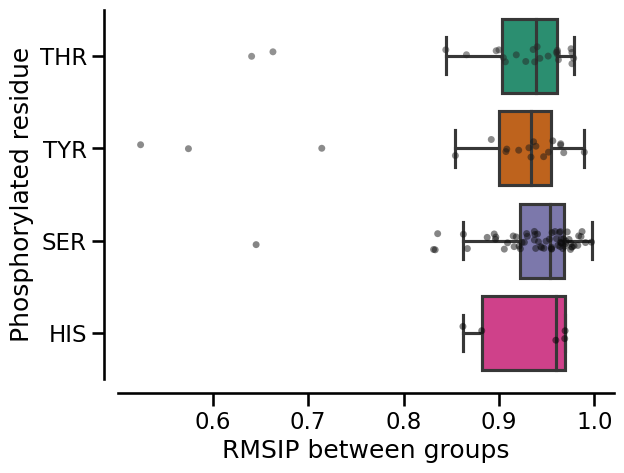

In [19]:
sns.set_context("talk")
ax = sns.boxplot(data=rmsips_df_nodups_single, x="median_between_groups",y="CHEM_COMP_ONE",
                 showfliers = False,
                 order=["THR","TYR","SER","HIS"], palette="Dark2")


ax = sns.stripplot(data=rmsips_df_nodups_single, x="median_between_groups",
                   y="CHEM_COMP_ONE",palette='dark:black',alpha=0.5,
                   jitter=True, order=["THR","TYR","SER","HIS"])

#plt.xlim(.9,1)
sns.despine(offset=10)
plt.xlabel("RMSIP between groups")
plt.ylabel("Phosphorylated residue")
plt.savefig(out_path / "rmsip_by_residue.png",dpi=150, bbox_inches='tight')


In [20]:
group_thr = rmsips_df_nodups.loc[rmsips_df_nodups["CHEM_COMP_ONE"]=="THR"]["median_between_groups"]
group_ser = rmsips_df_nodups.loc[rmsips_df_nodups["CHEM_COMP_ONE"]=="SER"]["median_between_groups"]
group_tyr = rmsips_df_nodups.loc[rmsips_df_nodups["CHEM_COMP_ONE"]=="TYR"]["median_between_groups"]
group_his = rmsips_df_nodups.loc[rmsips_df_nodups["CHEM_COMP_ONE"]=="HIS"]["median_between_groups"]
kruskal_stat, kruskal_pval = kruskal(group_thr, group_ser, group_tyr,group_his)
print(kruskal_stat, kruskal_pval)


5.422496406795708 0.14334838188915394


### Similarities in different groups

In [21]:
rmsip_melted = pd.melt(rmsips_df_nodups, value_vars=["median_within_phospho","median_within_nonphospho","median_between_groups"])

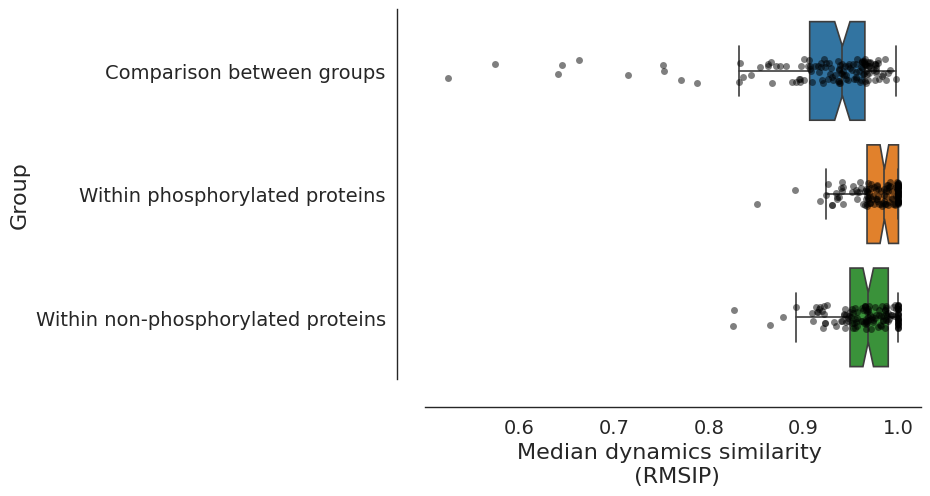

In [22]:
sns.set_context('poster')
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

ax = sns.boxplot(data=rmsip_melted, x='value',y='variable',notch=True,showfliers = False,
                order=["median_between_groups","median_within_phospho","median_within_nonphospho"])
ax = sns.stripplot(data=rmsip_melted, x='value',y='variable',ax=ax, 
                   color='black',alpha=.5, jitter=True,
                   order=["median_between_groups","median_within_phospho","median_within_nonphospho"])

ax.set_yticklabels(["Comparison between groups","Within phosphorylated proteins","Within non-phosphorylated proteins"])

plt.xlabel("Median dynamics similarity \n (RMSIP)",fontsize=16)
plt.ylabel("Group",fontsize=16)

#plt.xlim(.90,1)
sns.despine(offset=20)

plt.savefig(out_path / "boxplot_rmsip.png",dpi=120, bbox_inches='tight')


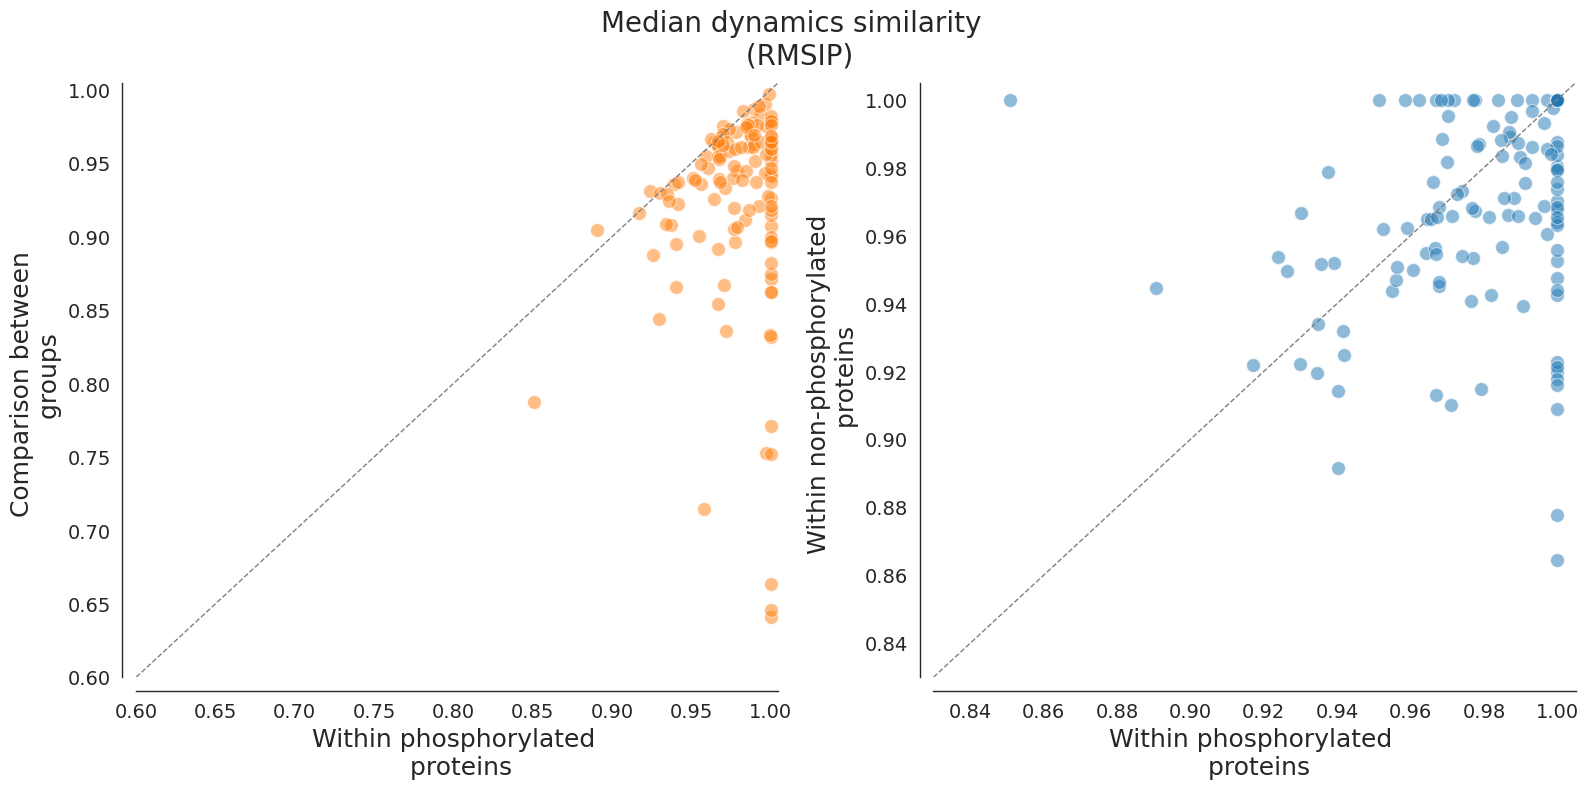

In [23]:
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

fig, axs = plt.subplots(1,2, figsize=(16,8))

sns.scatterplot(data=rmsips_df_nodups, x="median_within_phospho",y="median_between_groups",alpha=0.5,c="tab:orange",s=100,ax=axs[0])
add_identity(axs[0], color='gray', ls='--', lw=1)
axs[0].set_ylabel("Comparison between \n groups",fontsize=18)
axs[0].set_xlabel("Within phosphorylated \n proteins",fontsize=18)
axs[0].set_xlim(0.6,1.005)
axs[0].set_ylim(0.6,1.005)

# axs[0].text(.7,.645,"Chromobox protein\nhomolog 5",fontsize=11)
# axs[0].text(.88,.94,"Myosin regulatory\nlight chain",fontsize=11)

sns.scatterplot(data=rmsips_df_nodups, x="median_within_phospho",y="median_within_nonphospho",alpha=0.5,c="tab:blue",s=100,ax=axs[1])
add_identity(axs[1], color='gray', ls='--', lw=1)
axs[1].set_ylabel("Within non-phosphorylated \n proteins",fontsize=18)
axs[1].set_xlabel("Within phosphorylated \n proteins",fontsize=18)
axs[1].set_xlim(0.83,1.005)
axs[1].set_ylim(0.83,1.005)

sns.despine(offset=10)

plt.suptitle("Median dynamics similarity \n (RMSIP)",fontsize=20)

plt.tight_layout()

plt.savefig(out_path / "scatter_rmsips_phospho.png",dpi=120, bbox_inches='tight')


In [24]:
# Exclude examples with only one example in one case
rmsips_df_nodups_nona = rmsips_df_nodups.dropna()
rmsips_df_nodups_nona['dynamic_diffs'] = rmsips_df_nodups_nona["median_within_phospho"] - rmsips_df_nodups_nona["median_within_nonphospho"]

/tmp/ipykernel_299845/2789802838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsips_df_nodups_nona['dynamic_diffs'] = rmsips_df_nodups_nona["median_within_phospho"] - rmsips_df_nodups_nona["median_within_nonphospho"]


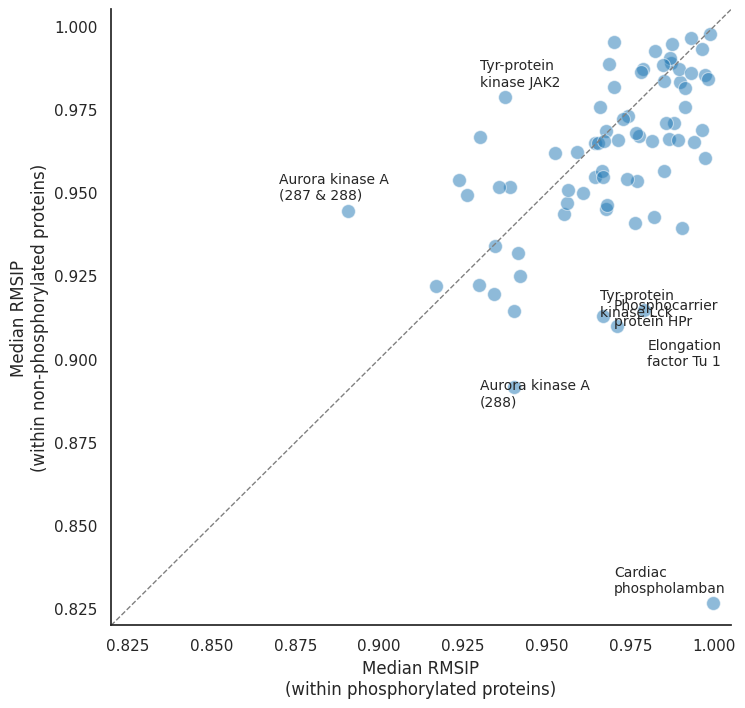

In [25]:
sns.set_context('notebook')
fig, axs = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(data=rmsips_df_nodups_nona, x="median_within_phospho",y="median_within_nonphospho",
                alpha=0.5,c="tab:blue",s=100,ax=axs)
add_identity(axs, color='gray', ls='--', lw=1)
axs.set_ylabel("Median RMSIP\n(within non-phosphorylated proteins)")
axs.set_xlabel("Median RMSIP\n(within phosphorylated proteins)")
axs.set_xlim(0.82,1.005)
axs.set_ylim(0.82,1.005)
sns.despine()

# O14965_287
plt.text(0.87, 0.948, "Aurora kinase A\n(287 & 288)",fontsize=10)
# O60674_1007
plt.text(0.930,0.982,"Tyr-protein\nkinase JAK2",fontsize=10)
# P61015_16
plt.text(0.97,0.83,"Cardiac\nphospholamban",fontsize=10)
# P0CE47_383
plt.text(0.98,0.898,"Elongation\nfactor Tu 1",fontsize=10)
# P07515_46
plt.text(0.97,0.91,"Phosphocarrier\nprotein HPr",fontsize=10)
# P06239_394
plt.text(0.966,0.9129,"Tyr-protein\nkinase Lck",fontsize=10)
# O14965_288
plt.text(0.93,0.886,"Aurora kinase A\n(288)",fontsize=10)

plt.savefig(out_path / "scatter_rmsip_phospho_vs_nonphospho.pdf", dpi=120, bbox_inches='tight')

### Comparison between groups

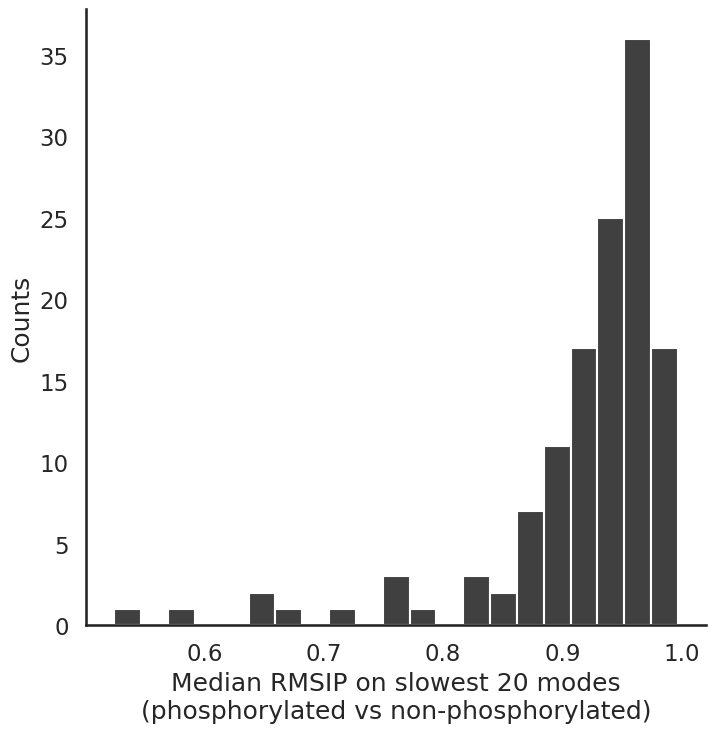

In [26]:
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(8,8))

sns.histplot(rmsips_df_nodups["median_between_groups"], color='black')
sns.despine()
plt.xlabel("Median RMSIP on slowest 20 modes\n(phosphorylated vs non-phosphorylated)")
plt.ylabel("Counts")

plt.savefig(out_path / "histogram_rmsip_betwen_groups.pdf",dpi=120,bbox_inches='tight')

## Fluctuations

### Correlations between fluctuations

In [1]:
# Calculate correlation between fluctuations profile correlations within phosphorylated structures and within non-phosphorylated structures
fluct_corr, fluct_pval = pearsonr(fluctuation_df_nodups['median_structure_phospho'],fluctuation_df_nodups['median_structure_nonphospho'])

NameError: name 'pearsonr' is not defined

#### Is there a difference between groups?
None that is statistically significant

In [28]:
paired_flucts_df = fluctuation_df_nodups[["median_structure_phospho","median_structure_nonphospho"]].dropna()
fluct_corr_stat, fluct_corr_pval = wilcoxon(paired_flucts_df["median_structure_phospho"],paired_flucts_df["median_structure_nonphospho"])
print(fluct_corr_stat, fluct_corr_pval)

3635.5 0.24150263369327096


#### What % of phosphosites have high fluctuation correlations between phospho and non-phospho?

In [30]:
sum(flucts_corr_summary["corr_between_groups"]>=.90) / len(flucts_corr_summary)

0.6796875

#### Plot the different groups

In [31]:
corrs_melted = pd.melt(flucts_corr_summary,value_vars=["corr_within_phospho","corr_within_nonphospho","corr_between_groups"])

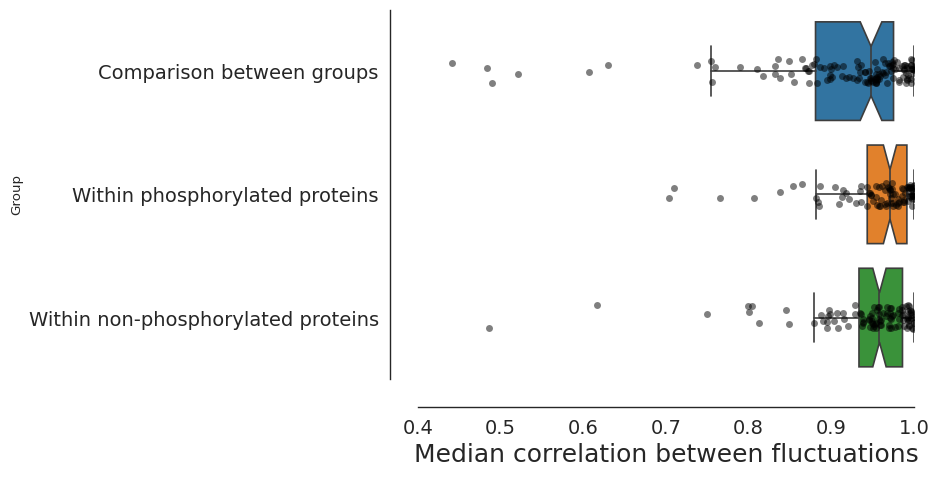

In [32]:
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

ax = sns.boxplot(data=corrs_melted, x='value',y='variable',notch=True,showfliers = False,
                order=["corr_between_groups","corr_within_phospho","corr_within_nonphospho"])
ax = sns.stripplot(data=corrs_melted, x='value',y='variable',ax=ax, 
                   color='black',alpha=.5, jitter=True,
                   order=["corr_between_groups","corr_within_phospho","corr_within_nonphospho"])

ax.set_yticklabels(["Comparison between groups","Within phosphorylated proteins","Within non-phosphorylated proteins"])
ax.set_xlabel("Median backbone RMSD (Å)",fontsize=18)

plt.xlabel("Median correlation between fluctuations")
plt.ylabel("Group")

plt.xlim(.40,1)
sns.despine(offset=20)

plt.savefig(out_path / "boxplot_flucts_corrs.png",dpi=120, bbox_inches='tight')


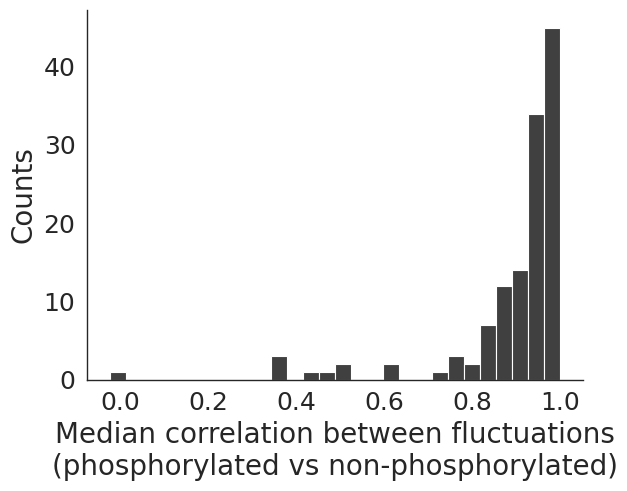

In [33]:
# Plot concordance between groups as a histogram
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":18,"ytick.labelsize":18})

sns.histplot(flucts_corr_summary["corr_between_groups"], color='black')
plt.xlabel("Median correlation between fluctuations\n(phosphorylated vs non-phosphorylated)",fontsize=20)
plt.ylabel("Counts",fontsize=20)
#plt.xlim(0,1)
sns.despine()
plt.savefig(out_path / "correlation_between_fluctuations.pdf",dpi=150,bbox_inches='tight')


### How different is the flexibility of phosphorylated proteins versus non-phosphorylated proteins?

In [34]:
psite_nodups = list(fluctuation_df_nodups["phosphosite"].unique())

In [35]:
# Do a KS test for each phosphosite: is the distribution of fluctuations sign. diff?
dynamics_ks_df = []
columns = ['phosphosite','statistic','pval']

for psite in psite_nodups:
    try:
        p_median = np.median(p_fluctuations[psite],axis=0)
        np_median = np.median(np_fluctuations[psite],axis=0)
        stat, pval = kstest(p_median, np_median)
        dynamics_ks_df.append([psite, stat, pval])
    except IndexError:
        print(psite)

dynamics_ks_df = pd.DataFrame(dynamics_ks_df,columns=columns)
adj_pvals = multipletests(list(dynamics_ks_df['pval']), alpha=0.05, method='fdr_bh')
reject = list(adj_pvals[0])
adj_pvals = list(adj_pvals[1])
dynamics_ks_df['reject'] = reject
dynamics_ks_df['adj_pvals'] = adj_pvals

In [36]:
ks_pvals_dict = {}
for idx, row in dynamics_ks_df.iterrows():
    psite = row['phosphosite']
    adj_pval = row['adj_pvals']
    ks_pvals_dict[psite] = adj_pval

In [37]:
colors = []
for idx, row in fluctuation_df_nodups.iterrows():
    
    psite = row['phosphosite']
    median_p = row['median_structure_phospho'] 
    median_np = row['median_structure_nonphospho']
    try:
        pval = ks_pvals_dict[psite]
        if pval > 0.05:
            colors.append('gray')
        else:
            if median_p > median_np:
                colors.append('tab:red')
            else:
                colors.append('tab:blue')
    except KeyError:
        print(f'Missing {psite}')
        colors.append('tab:gray')
        

In [ ]:
# What fraction of proteins have significant differences in their global dynamics?
sum(dynamics_ks_df['reject'])/len(dynamics_ks_df)

In [ ]:
sns.set_context('notebook')
sns.set_style('whitegrid')

plt.figure(figsize=(8,8))


ax4 = sns.scatterplot(data=fluctuation_df_nodups, c=colors, 
                      x="median_structure_phospho", y="median_structure_nonphospho",
                      alpha=.4,s=100)
add_identity(ax4, color='black', ls='--', lw=0.75)

plt.xlabel("Median squared fluctuation ($Å^2$) \n (phosphorylated)",fontsize=16)
plt.ylabel("Median squared fluctuation ($Å^2$) \n (non-phosphorylated)",fontsize=16)

ax4.set_xlim(-5,150)
ax4.set_ylim(-5,150)

plt.text(25,120,f"Pearson r: {fluct_corr:.2f}",fontsize=12)
plt.text(25,115, r"p-value: ${0:s}$".format(as_si(fluct_pval,2)),fontsize=12)

plt.text(85,70,"Transcription initiation \nfactor TFIID subunit 9",fontsize=12)
plt.text(120,30,"Chromobox protein \nhomolog 5",fontsize=12)

#plt.text(20, 45,"Cytochrome c oxidase \nsubunit 6A2",fontsize=12)
plt.text(33, 25,"Flagellar associated \nprotein",fontsize=12)

plt.text(32,1,"Cardiac \nphospholamban",fontsize=12)

sns.despine()
plt.savefig(out_path / "scatter_fluctuations_phospho_vs_nonphospho.png",dpi=120, bbox_inches='tight')

In [235]:
fluctuation_df_nodups.loc[(fluctuation_df_nodups["median_structure_phospho"]) & (fluctuation_df_nodups["median_structure_phospho"])]

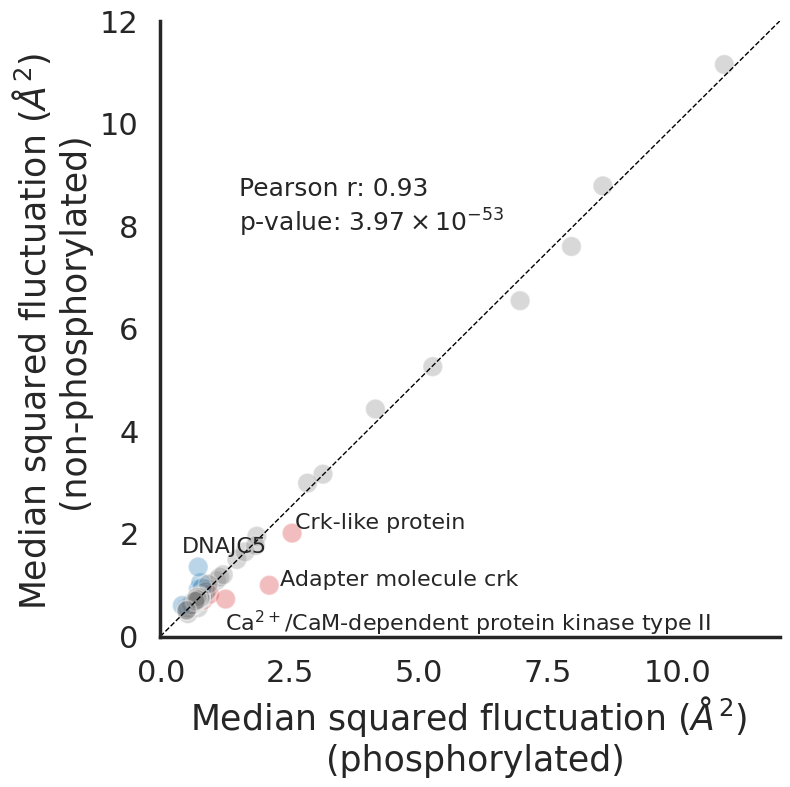

In [269]:
sns.set_context('poster')
sns.set_style('white')

plt.figure(figsize=(8,8))

ax3 = sns.scatterplot(data=fluctuation_df_nodups, c=colors,
                      x="median_structure_phospho", y="median_structure_nonphospho",
                      alpha=.3,s=200)
add_identity(ax3, color='black', ls='--', lw=1)

plt.xlabel("Median squared fluctuation ($Å^2$) \n (phosphorylated)",fontsize=25)
plt.ylabel("Median squared fluctuation ($Å^2$) \n (non-phosphorylated)",fontsize=25)

plt.text(1.5,8.6,f"Pearson r: {fluct_corr:.2f}",fontsize=18)
plt.text(1.5,7.9, r"p-value: ${0:s}$".format(as_si(fluct_pval,2)),fontsize=18)

plt.xlim(-0.02,12)
plt.ylim(-0.02,12)

plt.text(2.3,0.99,"Adapter molecule crk",fontsize=16)
plt.text(0.4,1.63, "DNAJC5",fontsize=16) # DnaJ homolog subfamily C member 5
plt.text(2.6,2.1,"Crk-like protein",fontsize=16)
plt.text(1.24, 0.1, r"Ca$^{2+}$/CaM-dependent protein kinase type II",fontsize=16)
#plt.text(1.5,0.5,"Protein phosphatase 1\nregulatory subunit 14A",fontsize=16)


sns.despine()
plt.savefig(out_path / "scatter_fluctuations_phospho_vs_nonphospho_zoom.pdf",dpi=120, bbox_inches='tight')


# Is there a particular tendency towards rigidification or flexibilization?

In [247]:
merged_fluctuations_df = fluctuation_df_nodups.merge(dynamics_ks_df,on="phosphosite")
merged_fluctuations_df['diffs'] = merged_fluctuations_df["median_structure_phospho"] - merged_fluctuations_df["median_structure_nonphospho"]

merged_fluctuations_df_sig = merged_fluctuations_df.loc[merged_fluctuations_df['reject']==True]
merged_fluctuations_df_sig_pos = merged_fluctuations_df_sig.loc[merged_fluctuations_df_sig['diffs']>0]
merged_fluctuations_df_sig_neg = merged_fluctuations_df_sig.loc[merged_fluctuations_df_sig['diffs']<0]

In [248]:
print("Fraction where the protein becomes more rigid (diff <0)")
print(len(merged_fluctuations_df_sig_neg) / len(merged_fluctuations_df_sig))
print("Fraction where the protein becomes more flexible (diff >0)")
print(len(merged_fluctuations_df_sig_pos) / len(merged_fluctuations_df_sig))

Fraction where the protein becomes more rigid (diff <0)
0.42857142857142855
Fraction where the protein becomes more flexible (diff >0)
0.5714285714285714


## How does RMSD relate to changes in fluctuations?

In [251]:
fluctuation_rmsd_merged = fluctuation_df_nodups.merge(rmsd_summary_df, on="phosphosite")

In [252]:
fluctuation_rmsd_merged["rmsd_diff"] = fluctuation_rmsd_merged["rmsd_within_phospho"] - fluctuation_rmsd_merged["rmsd_within_nonphospho"]
fluctuation_rmsd_merged["fluct_diff"] = fluctuation_rmsd_merged["median_structure_phospho"] - fluctuation_rmsd_merged["median_structure_nonphospho"]

Text(0, 0.5, 'Difference in fluctuations\n(phosphorylated - non-phosphorylated)')

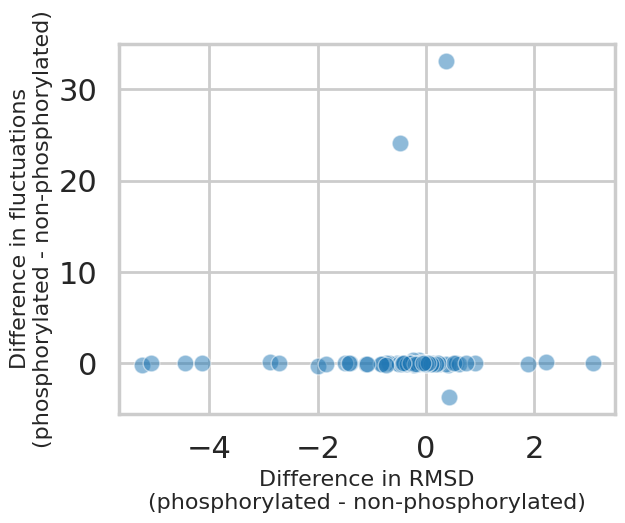

In [259]:
sns.scatterplot(data=fluctuation_rmsd_merged, x="rmsd_diff", y="fluct_diff",alpha=0.5)
plt.xlabel("Difference in RMSD\n(phosphorylated - non-phosphorylated)",fontsize=16)
plt.ylabel("Difference in fluctuations\n(phosphorylated - non-phosphorylated)",fontsize=16)

Text(0, 0.5, 'Difference in fluctuations\n(phosphorylated - non-phosphorylated)')

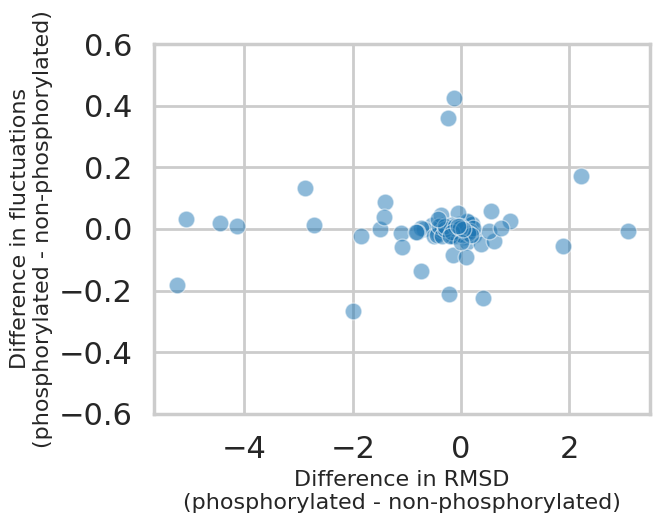

In [258]:
# Hiding the outliers
sns.scatterplot(data=fluctuation_rmsd_merged, x="rmsd_diff", y="fluct_diff",alpha=0.5)
plt.ylim(-0.6, 0.6)

plt.xlabel("Difference in RMSD\n(phosphorylated - non-phosphorylated)",fontsize=16)
plt.ylabel("Difference in fluctuations\n(phosphorylated - non-phosphorylated)",fontsize=16)

## Can differences in global dynamics be explained by differences in fluctuation correlations?
Compare the median fluctuation correlation between groups to the median difference in overall fluctuations

In [271]:
joint_flucts_df = fluctuation_df_nodups.merge(flucts_corr_summary, on="phosphosite")

joint_flucts_df["diffs"] = joint_flucts_df["median_structure_phospho"] - joint_flucts_df["median_structure_nonphospho"]
joint_flucts_df["abs_diffs"] = abs(joint_flucts_df["diffs"])

In [272]:
# No correlation between fluctuation differences and fluctuation correlations
diffs_corr_corr, diffs_corr_pval = pearsonr(joint_flucts_df['diffs'],joint_flucts_df['corr_between_groups'])
print(diffs_corr_corr, diffs_corr_pval)

0.016965205933083927 0.849254133619655


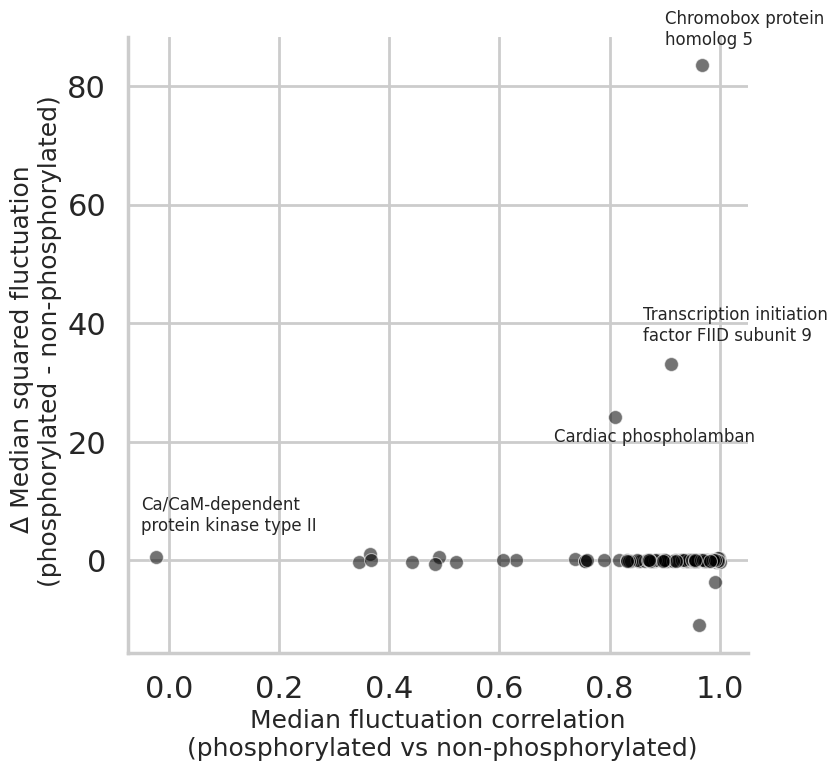

In [273]:
sns.set_style('whitegrid')
sns.set_context('poster')

plt.figure(figsize=(8,8))

sns.scatterplot(data=joint_flucts_df,y='diffs',x='corr_between_groups',s=100,
                color='black',alpha=.55)
plt.xlabel("Median fluctuation correlation\n (phosphorylated vs non-phosphorylated)",fontsize=18)
plt.ylabel("Δ Median squared fluctuation \n (phosphorylated - non-phosphorylated)",fontsize=18)

# O62305_284
plt.text(-0.05,5,"Ca/CaM-dependent\nprotein kinase type II",fontsize=12)
# Q61686_13
plt.text(0.9,87,"Chromobox protein \nhomolog 5",fontsize=12)
# Q16594_8
plt.text(0.86,37,"Transcription initiation\nfactor FIID subunit 9",fontsize=12)
# P61015_16
plt.text(0.70,20,"Cardiac phospholamban",fontsize=12)

sns.despine()
plt.savefig(out_path / "scatter_corrs_vs_flucts.png",dpi=120, bbox_inches='tight')


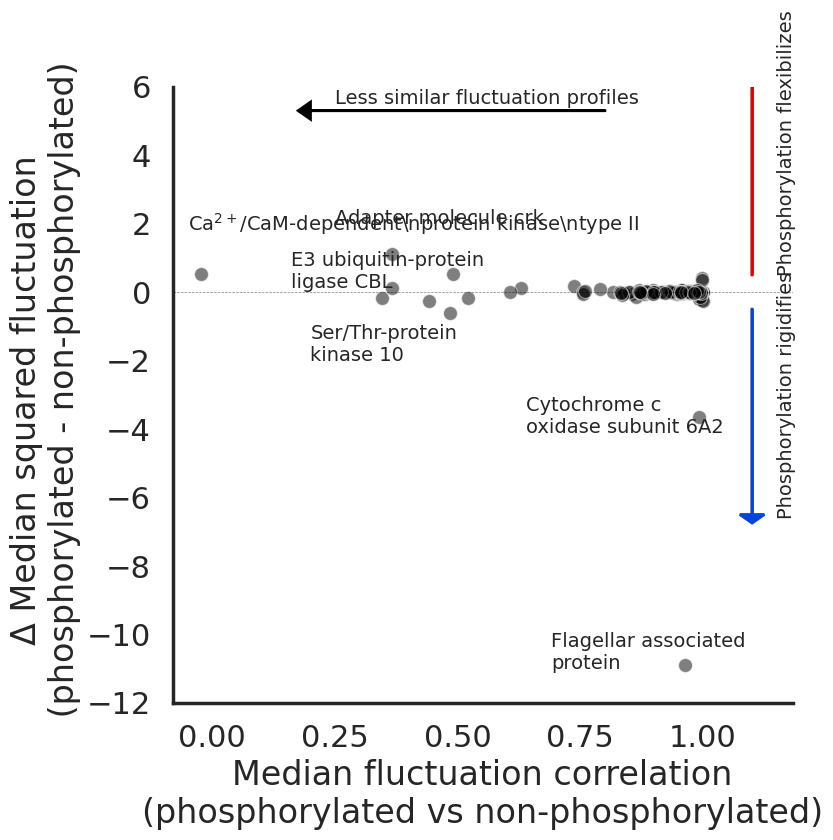

In [278]:
sns.set_style('white')
sns.set_context('poster')

plt.figure(figsize=(8,8))


sns.scatterplot(data=joint_flucts_df,y='diffs',x='corr_between_groups',s=100,
                color='black',alpha=.5)
plt.xlabel("Median fluctuation correlation\n(phosphorylated vs non-phosphorylated)")
plt.ylabel("Δ Median squared fluctuation \n (phosphorylated - non-phosphorylated)")

plt.ylim(-12,6)

#P07471_23
plt.text(0.64,-4.1,"Cytochrome c \noxidase subunit 6A2",fontsize=14)
#A0A2K3D4W3_328
plt.text(0.69,-11,"Flagellar associated\nprotein",fontsize=14)
# O62305_284
plt.text(-0.05,1.8,r"Ca$^{2+}$/CaM-dependent protein kinase type II",fontsize=14)
#P46108_221
plt.text(0.25,2.,"Adapter molecule crk",fontsize=14)
#O94804_185
plt.text(0.2,-2,"Ser/Thr-protein\nkinase 10",fontsize=14)
#P22681_371
plt.text(0.16,0.13,"E3 ubiquitin-protein\nligase CBL",fontsize=14)

plt.axhline(0,ls='--',lw=0.5,color='black',alpha=0.5)

# Y axis
#plt.arrow(1.1, 2, 0, 4, width=0.0005, head_width=10, head_length=50*0.005, **{'color':'xkcd:red'})
#plt.arrow(1.1, 0.5, 0, 6, width=0.0005, head_width=10*0.005, head_length=50*0.05, **{'color':'xkcd:red'})
plt.arrow(1.1, 0.5, 0, 6, width=0.0005, head_width=10*0.005, head_length=50*0.05, **{'color':'xkcd:red'})


plt.text(1.15, 0.6, "Phosphorylation flexibilizes",fontsize=14, **{'rotation':90})

plt.arrow(1.1, -0.5, 0, -6, width=0.0005, head_width=10*0.005, head_length=50*0.005, **{'color':'xkcd:blue'})
plt.text(1.15, -6.5, "Phosphorylation rigidifies",fontsize=14, **{'rotation':90})

# Correlation arrow
plt.arrow(0.8, 5.3, -0.6, 0, width=0.0005, head_width=10*0.05,head_length=50*0.0005, **{'color':'black'})
plt.text(0.25, 5.5, "Less similar fluctuation profiles",fontsize=14)


sns.despine()
plt.savefig(out_path / "scatter_corrs_vs_flucts_zoom.pdf",dpi=120, bbox_inches='tight')
